**Importance Score for Dataset Training Samples**

1. Dataset: vehicles.csv
2. Classifier: Linear SVM

**Experiment Steps**
1. Load and explore the data. Initialize the classifier.
2. Create a function that takes training data, classifier as input and calculate sensitivity of model for each data point.
3. Calculate the sensitivity db by using the above function and store it in a sensitivity.csv file.
4. Visualize the results to get the answer for the following questions:

    4.1. List all the datapoints that increased accuracy when removed? Are all those data points outliers?
    4.2. Group and visualize the data 
        - Group data and see positive and negative impact of each group to the model's accuracy.
        - Are there any errors in data collection ?

In [64]:
import warnings
warnings.simplefilter("ignore", UserWarning)

%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../datasets/vehicles.csv')

**Exploratory Data Analysis**

This data set has 4 different classes and it is a multi-class classification problem. Dataset looks good as it doesn't have any null values. It has 18 feature columns. I am taking reference from my previous work issue#2 https://github.com/shashigharti/PRESC/blob/master/dev/shashigharti/train-n-test-model-for-vehicle-recognition-from-silhouette-I.ipynb and this dataset has 51 outliers. 


We will create the list of all the outliers which will be use in this notebook as well.

In [3]:
print("No of Classes: {}".format(df['Class'].unique()))
print("All Columns: {}".format(df.columns))
print("Data Info: {}".format(df.info()))

No of Classes: ['van' 'saab' 'bus' 'opel']
All Columns: Index(['COMPACTNESS', 'CIRCULARITY', 'DISTANCE_CIRCULARITY', 'RADIUS_RATIO',
       'PR.AXIS_ASPECT_RATIO', 'MAX.LENGTH_ASPECT_RATIO', 'SCATTER_RATIO',
       'ELONGATEDNESS', 'PR.AXIS_RECTANGULARITY', 'MAX.LENGTH_RECTANGULARITY',
       'SCALED_VARIANCE_MAJOR', 'SCALED_VARIANCE_MINOR',
       'SCALED_RADIUS_OF_GYRATION', 'SKEWNESS_ABOUT_MAJOR',
       'SKEWNESS_ABOUT_MINOR', 'KURTOSIS_ABOUT_MAJOR', 'KURTOSIS_ABOUT_MINOR',
       'HOLLOWS_RATIO', 'Class'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   COMPACTNESS                846 non-null    int64 
 1   CIRCULARITY                846 non-null    int64 
 2   DISTANCE_CIRCULARITY       846 non-null    int64 
 3   RADIUS_RATIO               846 non-null    int64 
 4   PR.AXIS_ASPECT_RATIO 

In [4]:
feature_cols = ['COMPACTNESS', 'CIRCULARITY', 'DISTANCE_CIRCULARITY', 'RADIUS_RATIO',
       'PR.AXIS_ASPECT_RATIO', 'MAX.LENGTH_ASPECT_RATIO', 'SCATTER_RATIO',
       'ELONGATEDNESS', 'PR.AXIS_RECTANGULARITY', 'MAX.LENGTH_RECTANGULARITY',
       'SCALED_VARIANCE_MAJOR', 'SCALED_VARIANCE_MINOR',
       'SCALED_RADIUS_OF_GYRATION', 'SKEWNESS_ABOUT_MAJOR',
       'SKEWNESS_ABOUT_MINOR', 'KURTOSIS_ABOUT_MAJOR', 'KURTOSIS_ABOUT_MINOR',
       'HOLLOWS_RATIO']
label_col = ['Class']

# Features and Labels
X = df[feature_cols]
y = df[label_col]
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size = .3, random_state = 1)

In [25]:
list_of_outliers = list()
# Max value based on boxplot to filter outliers of 8 columns where outliers are identified. 
df_columns_with_outliers = pd.DataFrame([[255, 77, 13, 288, 980, 88, 19, 40]], columns=['RADIUS_RATIO', 
                                                                                'PR.AXIS_ASPECT_RATIO', 
                                                                                'MAX.LENGTH_ASPECT_RATIO', 
                                                                                'SCALED_VARIANCE_MAJOR', 
                                                                                'SCALED_VARIANCE_MINOR', 
                                                                                'SKEWNESS_ABOUT_MAJOR', 
                                                                                'SKEWNESS_ABOUT_MINOR', 
                                                                                'KURTOSIS_ABOUT_MAJOR'])

# Loop through all the columnw with outliers and find all the outlier rows greater 
# than max value(for that specific column)
for i, column in enumerate(df_columns_with_outliers.columns):
    outliers_indexes = df[column][df[column] > df_columns_with_outliers[column][0]].index.values.tolist()
    list_of_outliers.extend(outliers_indexes)

print('Outliers:{}'.format(list_of_outliers))
print('Outliers Count:{}'.format(len(list_of_outliers)))

Outliers:[37, 135, 388, 4, 37, 100, 135, 291, 388, 523, 706, 4, 37, 100, 127, 135, 291, 388, 391, 523, 544, 706, 815, 388, 85, 321, 687, 835, 4, 37, 100, 135, 230, 291, 388, 523, 655, 706, 44, 113, 123, 190, 346, 400, 505, 516, 623, 761, 796, 797, 132]
Outliers Count:51


**Importance Score Calculation**

The next step is to calculate the importance score for each data point. In order to calculate the importance score I have used the following method:

1. Run a loop for n_rows number of times. n_rows is the total number of rows in the dataset.
2. In each pass, remove the data row for that index i. i is the current index in the loop.
3. Use this db and train the classifier. 
4. Calculate the predicted accuracy and store it in the list.
5. After the completion of the loop n_rows time, we will have the list of accuracy score for each data point removed.

In [18]:
def sensitivity(clf, X, y, accuracy):
    
    """This function loop through total numbers of rows. In each loop, it removes that data point and 
    trains the classifier and calculates the accuracy for that pass. The calculated accuracies for each pass
    is stored in the list.
    
    
    Parameters
    ----------
    clf: Classifier
    X : Data with Feature Column.
    y : Label for each data row.
    accuracy: Base Accuracy for the dataset.
    
    Returns
    -------
    datasets_df : Dataframe with the list of all the accuracy details
    """
    
    
    datasets_list = list()
    for i in range(0, (X.shape[0] - 1)):
        r_class = y.iloc[i][0]
    
        X_new = X.iloc[X.index != i]
        y_new = y.iloc[y.index != i]

        X_train, X_test, y_train, y_test = train_test_split(X_new, y_new.values.ravel(), test_size = .3, random_state = 1)
    
        clf.fit(X_train, y_train) 
        y_pred = clf.predict(X_test)
        n_accuracy = round(accuracy_score(y_test, y_pred), 2)
        diff_in_accuracy = abs(n_accuracy - accuracy)
        datasets_list.append([i, r_class, accuracy, n_accuracy, (n_accuracy - accuracy), diff_in_accuracy])

    datasets_df = pd.DataFrame(datasets_list, columns =['Idx of Removed Row', 'Class','Base Accuracy', 'Accuracy', 'Change in Accuracy', 'Change in Accuracy(ABS)']) 
    return datasets_df 

In [19]:
# clf = SVC(kernel='linear')
# clf.fit(X_train, y_train) 
# y_pred = clf.predict(X_test)
# accuracy = round(accuracy_score(y_test, y_pred), 2)

# # Calculate Sensitivity in Models' Performance With/Without Datapoint
# df = sensitivity(clf, X, y, accuracy)
# df.to_csv (r'files/sensitivity.csv', index = False, header=True)

In [26]:
df_sensitivity = pd.read_csv('files/sensitivity.csv')
df_sensitivity.head()

,Idx of Removed Row,Class,Base Accuracy,Accuracy,Change in Accuracy,Change in Accuracy(ABS)
0,0,van,0.78,0.78,0.0,0.0
1,1,van,0.78,0.78,0.0,0.0
2,2,saab,0.78,0.78,0.0,0.0
3,3,van,0.78,0.78,0.0,0.0
4,4,bus,0.78,0.78,0.0,0.0


The sensitivity data that we generate has following fields 
1. Accuracy: Models' accuracy 
2. Change in Accuracy: New Calculated Accuracy By Removing a Data Point - Base Accuracy
3. Change in Accuracy(Absolute): New Calculated Accuracy By Removing a Data Point - Base Accuracy
4. Idx of Removed Row: Original index of the removed data row
5. Class: Label of the Removed Row
6. Base Accuracy: Accuracy of the full dataset

**Importance Score Analysis**

***Visualize the results to get the answer for the following questions:***

1. List all the datapoints that increased accuracy when removed? Are all those data points outliers?
2. Group and visualize the data 
        - Group data and see positive and negative impact of the each group to the model's accuracy.
        - Are there any errors in data collection ?  

***Test 1: List all the datapoints that increased accuracy when removed? Are all those data points outliers?***

In [66]:
# Get all datapoints that causes reduction in accuracy
data_points_that_reduces_accuracy = df_sensitivity[df_sensitivity['Change in Accuracy'] > 0].sort_values(by=['Change in Accuracy'])['Change in Accuracy'].index.values
print("Data points that reduces accuracy:{}".format(data_points_that_reduces_accuracy))


# Are any of the above datapoints outliers
data_points_that_are_outliers = [data_point for data_point in data_points_that_reduces_accuracy if data_point in list_of_outliers]
print("Data points that are outliers:{}".format(data_points_that_are_outliers))

Data points that reduces accuracy:[ 19 595 597 598 599 600 601 594 602 609 610 611 613 614 615 603 618 593
 590 574 575 576 577 578 701 592 580 582 584 585 586 588 589 581 619 620
 621 646 650 651 653 663 670 645 671 673 695 697 698 699 700 672 644 643
 642 626 627 628 629 630 631 632 633 634 635 636 638 639 640 641 573 572
 579  89  73  77  78  79  80  81  82  71  84  86  87  88 563  90  91  92
  85  70  64  63  20  21  22  23  24  29  31  32  38  43  52  56  57  59
  60  61  62  93  94 702  96 462  95 493 501 504 534 536 537 542 543 544
 545 546 548 549 550 562 458 457 471 409 455 456  97 426 410  99 100 605
 547 688 596 617 607 608 571 606 622 623 654 652 624 583  58 625 587  83
 591 637 655 570]
Data points that are outliers:[85, 544, 100, 623, 655]


No, not all the datapoints that increases accuracy when removed(or viceversa) are not outliers. Only 5 of them are outliers.

***Test II: Group and visualize the data***

In [85]:
############# Add Range Field #############
df_sensitivity_n = df_sensitivity.copy()
interval = 10
df_sensitivity_n['Index Range'] = ''
ids = df_sensitivity_n['Idx of Removed Row']

    
# Loop through the data with given interval
for rng in range(0, 900, interval):
    start = rng
    end = start + interval
    rng = "{} - {}".format(start, end)
    for i in range(start, end):
        if i in ids:
            df_sensitivity_n.loc[i, 'Index Range'] = rng

############# Create a crosstab table of range vs accuracy #############
df_avg_accuracy_change_by_data_cluster = df_sensitivity_n.copy()
ranges = df_sensitivity_n['Index Range'].unique()
tmp_lst = []

for grp in ranges:
    # Get avg positive change for the group 'grp'
    avg_postitive_change = df_avg_accuracy_change_by_data_cluster[(df_avg_accuracy_change_by_data_cluster['Index Range'] == grp) & (df_avg_accuracy_change_by_data_cluster['Change in Accuracy'] > 0)]['Change in Accuracy'].mean()
    
    
    avg_negative_change = df_avg_accuracy_change_by_data_cluster[(df_avg_accuracy_change_by_data_cluster['Index Range'] == grp) & (df_avg_accuracy_change_by_data_cluster['Change in Accuracy'] < 0)]['Change in Accuracy'].mean()
    tmp_lst.append([grp, avg_postitive_change, avg_negative_change])
        
df_avg_accuracy_change_by_data_cluster = pd.DataFrame(tmp_lst, columns = ['Range', 'Positive Change', 'Negative Change'], index = ranges) 

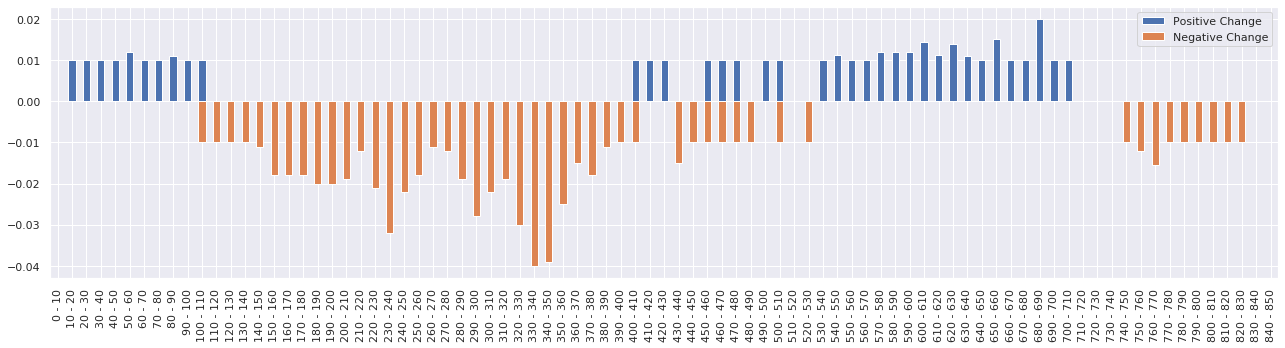

In [86]:
sns.set()
df_avg_accuracy_change_by_data_cluster.plot(kind='bar', stacked=True, figsize=(22, 5))